# LSST Stack Scarlet Deblender COSMOS Tutorial

This tutorial is designed to illustrate how to run the multiband deblender (*scarlet*) in the LSST stack on blended sources within the COSMOS field, showing the results of deblending Subaru-HSC images alongside Hubble Space Telescope images (if available).

## Imports


We'll start with some standard imports of both LSST and third-party packages, and a couple of small scripts included alongside this notebook (makeCutout.py and showMultibandImage.py). HST COSMOS images are stored on LSST dev machines; if you don't have access to them, you'll need to download them yourself from [here](http://cosmos.astro.caltech.edu/page/hst) and modify path_hst and path_candels.

In [1]:
import numpy as np
from lsst.daf.persistence import Butler
from lsst.geom import Box2I, Box2D, Point2I, Point2D, Extent2I, Extent2D, SpherePoint, degrees
from lsst.afw.image import Exposure, Image, PARENT, MultibandExposure, MultibandImage
from lsst.afw.detection import MultibandFootprint
import lsst.meas.extensions.scarlet as scarlet
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, AsinhStretch
from makeCutout import cutout_HST
from showMultibandImage import showRGB
from skimage.transform import resize
import os
import matplotlib.pyplot as plt
%matplotlib inline

path_hst = "/project/sr525/hstCosmosImages"
path_candels = os.path.join(path_hst, 'candels')

## Reading Data

We'll be retrieving data using the `Butler` tool, which manages where various datasets are stored on the filesystem (and can in principle manage datasets that aren't even stored as files, though all of these are).

We start by creating a `Butler` instance, pointing it at a *Data Repository* (which here is just a root directory). In this tutorial, we have the option of using several different sets of *co-added* Subaru HSC images from the COSMOS survey field - more on that below.

In [2]:
butler = Butler("/datasets/hsc/repo/rerun/private/yusra/deblender-sprint/w_2019_18_2k")

Datasets managed by a butler are identified by a dictionary *Data ID* (specifying things like the visit number or sky patch) and a string *DatasetType* (such as a particular image or catalog).  Different DatasetTypes have different keys, while different instances of the same Dataset Type have different values.  All of the datasets we use in this tutorial will correspond to the same *tract* of sky, so they'll have at least the keys in the dictionary in the next cell (they will also have `filter`, but with different values). However, the tract is split into *patches* of different sizes depending on the path chosen above - 1kx1k pixels for "small", 2kx2k for "medium", and 4kx4k for the standard default. The area of the sky we want to look at lands in a different patch depending on the tract size, so we need to look up its position in pixel coordinates using the butler's `skymap`.

In [3]:
skymap = butler.get("deepCoadd_skyMap")
ra, dec = 150.193152, +2.244097
#ra, dec = 150.0566, 2.2070
spherePoint = SpherePoint(ra, dec, degrees)
tract = skymap.findTract(spherePoint).getId()
if tract != 9813:
    raise RuntimeError('ra, dec is in tract {} != 9813'.format(tract))
patch = skymap[tract].findPatch(spherePoint)
patchname = ','.join([str(x) for x in patch.getIndex()])
dataId = {"tract": tract, "patch": patchname}

We can now use those to load a set of *grizy* coadds, which we'll put directly in a dictionary.  The result of each `Butler.get` call is in this case an `lsst.afw.image.Exposure` object, an image that actually contains three "planes" (the main image, a bit mask, and a variance image) as well as many other objects that describe the image, such as its PSF and WCS.  Note that we (confusingly) use `Exposures` to hold coadd images as well as true single-exposure images, but combine them into a `MultibandExposure`, which contains an exposure in each band.

The DatasetType here is `deepCoadd_calexp` (a coadd on which we've already done some additional processing, such as subtracting the background and setting some mask values), and the extra `filter` argument gets appended to the Data ID. We have added a `_sub` to the end of the DatasetType to let the Butler know that we are adding a bounding box `bbox` so that we only extract a subset of the image. Removing the `_sub` and `bbox` argument will load the entire multiband exposure into memory.

In [4]:
frame = 60
wcs = skymap[tract].getWcs()
point = wcs.skyToPixel(spherePoint)
sampleBBox = Box2I(Point2I(point[0]-frame, point[1]-frame), Extent2I(2*frame, 2*frame))
filters = "grizy"
coadds = [butler.get("deepCoadd_calexp_sub", dataId, filter="HSC-{}".format(f.upper()), bbox=sampleBBox) for f in filters]
coadds = MultibandExposure.fromExposures(filters, coadds)

This section attempts to extract Hubble Space Telescope images of the galaxy from the COSMOS field. The COSMOS survey itself has reasonably deep imaging in F814W (a filter which roughly covers HSC-I+Z). A smaller region from the CANDELS survey has deeper F814W coverage as well as F606W (roughly HSC-R) and two near-IR bands at lower spatial resolution (0.06 arcsec pixels rather than 0.03), which we'll resample via interpolation to 0.03".

In [5]:
scale_hsc = 0.168
scale_hst = {'acs_cos': 0.03, 'wfc3_cos': 0.06}
scale_hsc_to_hst = scale_hsc/scale_hst['acs_cos']
plot = False
filters_candels_acs = ['F606W', 'F814W']
filters_candels_wfc3 = ['F125W']
filters_candels_all = filters_candels_acs + filters_candels_wfc3
data_hst = {}
for band in filters_candels_all:
    candels_filename = os.path.join(path_candels, "hlsp_candels_hst_{}-tot_{}_v1.0_drz.fits")
    camera = 'acs_cos' if band in filters_candels_acs else 'wfc3_cos'
    hdu_candels = fits.open(candels_filename.format(camera, band.lower()))
    wcs_candels = WCS(hdu_candels[0].header)
    wcs_candels.sip = None
    coord_candels = SkyCoord(ra, dec, unit='deg')
    if wcs_candels.footprint_contains(coord_candels):
        pixel = np.array([np.int(np.round(x)) for x in wcs_candels.world_to_pixel(coord_candels)][::-1])
        frame_hst = np.int(np.ceil(frame*scale_hsc/scale_hst[camera]))
        img = hdu_candels[0].data[pixel[0]-frame_hst:pixel[0]+frame_hst,pixel[1]-frame_hst:pixel[1]+frame_hst]
        if camera == 'wfc3_cos':
            img = resize(img, [2*x for x in img.shape])/4.
        if plot:
            fig, ax = plt.subplots(1, 1, figsize=(20,20))
            ax.imshow(np.log10(img), origin='bottom')
        data_hst[band]= {'CANDELS': img}

data_cosmos = {}
for band in ['F814W']:
    if band not in data_hst:
        data_hst[band] = {}
    data_hst[band]['COSMOS'] = cutout_HST(ra, dec, width=np.ceil(2*frame*scale_hsc), return_data=True, path=path_hst)[0][0][1].data
    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(20,20))
        ax.imshow(np.log10(data_hst[band]['COSMOS']), origin='bottom')

INFO:astropy:
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                


INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
/project/sr525/hstCo

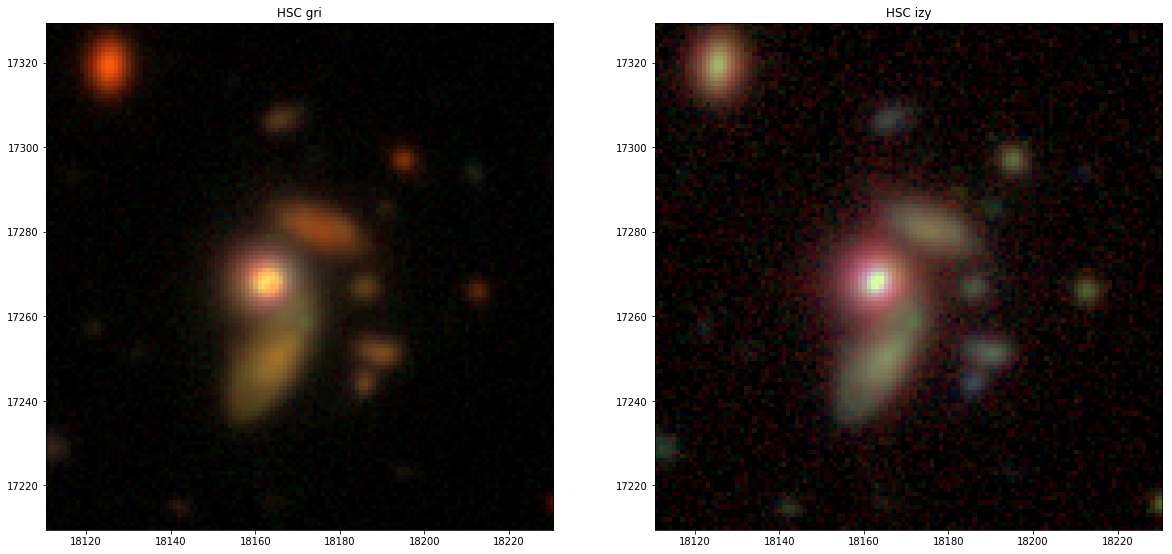

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].set_title("HSC gri")
showRGB(coadds[:"z"].image, ax=axes[0])
axes[1].set_title("HSC izy")
showRGB(coadds["i":].image, ax=axes[1])

## Basic Processing

Now we'll try the regular LSST processing tasks, with a simpler configuration than we usually use to process coadds, just to avoid being distracted by complexity.  This includes

 - Detection (`SourceDetectionTask`): given an `Exposure`, find above-threshold regions and peaks within them (`Footprints`), and create a *parent* source for each `Footprint`.
 - Deblending (`MultibandDeblendTask`): given a `MultibandExposure` and a catalog of parent sources, create a *child* source for each peak in every `Footprint` that contains more than one peak.  Each child source is given a `HeavyFootprint`, which contains both the pixel region that source covers and the fractional pixel values associated with that source. A `SourceDeblendTask` is also available using the single band SDSS-HSC deblender that takes a single band `Exposure`).
 - Measurment (`SingleFrameMeasurementTask`): given an `Exposure` and a catalog of sources, run a set of "measurement plugins" on each source, using deblended pixel values if it is a child. Notice that measurement is still performed on single band catalogs, since none of the measurement algorithms work for multiband data.

We'll start by importing these, along with the `SourceCatalog` class we'll use to hold the outputs.

In [7]:
from lsst.meas.algorithms import SourceDetectionTask
from lsst.meas.extensions.scarlet import ScarletDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.afw.table import SourceCatalog

We'll now construct all of these `Tasks` before actually running any of them.  That's because `ScarletDeblendTask` and `SingleFrameMeasurementTask` are constructed with a `Schema` object that records what fields they'll produce, and they modify that schema when they're constructed by adding columns to it.  When we run the tasks later, they'll need to be given a catalog that includes all of those columns, **but we can't add columns to a catalog that already exists**.

To recap, the sequence looks like this:

 1. Make a (mostly) empty schema.
 2. Construct all of the `Task`s (in the order you plan to run them), which adds columns to the schema.
 3. Make a `SourceCatalog` object from the *complete* schema.
 4. Pass the same `SourceCatalog` object to each `Task` when you run it.

In [8]:
schema = SourceCatalog.Table.makeMinimalSchema()

detectionTask = SourceDetectionTask(schema=schema)

config = ScarletDeblendTask.ConfigClass()
config.maxIter = 100
deblendTask = ScarletDeblendTask(schema=schema, config=config)

# We'll customize the configuration of measurement to just run a few plugins.
# The default list of plugins is much longer (and hence slower).
measureConfig = SingleFrameMeasurementTask.ConfigClass()
measureConfig.plugins.names = ["base_SdssCentroid", "base_PsfFlux", "base_SkyCoord"]
# "Slots" are aliases that provide easy access to certain plugins.
# Because we're not running the plugin these slots refer to by default,
# we need to disable them in the configuration.
measureConfig.slots.apFlux = None
#measureConfig.slots.instFlux = None
measureConfig.slots.shape = None
measureConfig.slots.modelFlux = None
measureConfig.slots.calibFlux = None
measureConfig.slots.gaussianFlux = None
measureTask = SingleFrameMeasurementTask(config=measureConfig, schema=schema)

The first step we'll run is detection, which actually returns a new `SourceCatalog` object rather than working on an existing one. Instead, it takes a `Table` object, which is sort of like a factory for records.  We won't use it directly after this, and it isn't actually necessary to make a new `Table` every time you run `SourceDetectionTask` (but you can only create one after you're done adding columns to the schema).

`Task`s that return anything do so via a `lsst.pipe.base.Struct` object, which is just a simple collection of named attributes.  The only return value we're interested is `sources`.  That's our new `SourceCatalog`.

In [9]:
table = SourceCatalog.Table.make(schema)
detectionResult = detectionTask.run(table, coadds["r"])
catalog = detectionResult.sources

Now run the deblender:

In [10]:
result = deblendTask.run(coadds, catalog)

/home/dtaranu/src/lsst/autograd/_eupspkg/binary/autograd/master-g6a9ef8c4bf/lib/python/autograd-1.2-py3.7.egg/autograd/numpy/fft.py:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return anp.pad(x, pads, 'constant')[slices]


`ScarletDeblendTask` always returns a `templateCatalog` that contains the model outputs from *scarlet*.

The deblender itself sets the `parent` column for each source, which is `0` for objects with no parent, and all of the columns that begin with `deblend_` and also adds new rows to the catalog for each child. It does *not* remove the parent rows it created those child rows from, and this is intentional, because we want to measure both "interpretations" of the blend family: one in which there is only one object (the parent version) and one in which there are several (the children). Before doing any science with the outputs of an LSST catalog, it's important to remove one of those interpretations (typically the parent one).  That can be done by looking at the `deblend_nChild` and `parent` fields:

 - `parent` is the ID of the source from which this was deblended, or `0` if the source is itself a parent.
 - `deblend_nChild` is the number of child sources this source has (so it's `0` for sources that are themselves children or were never blended).
 
Together, these define two particularly useful filters:

 - `deblend_nChild == 0`: never-blended object or de-blended child
 - `deblend_nChild == 0 and parent == 0`: never-blended object
 
The first is what you'll usually want to use; the second is what to use if you're willing to throw away some objects (possibly many) because you don't trust the deblender.

The last processing step for our purposes is running measurement, which must be done on each catalog, in each band (if we want measurements for all of them):

In [11]:
measCat = result[0] if result[0] is not None else result[1]
measureTask.run(measCat["r"], coadds['r'])
measureTask.run(measCat["i"], coadds['i'])

Due to an unfortunate bug in the deblender task, the resulting catalogs are not contiguous and we need to copy them into new objects to use them appropriately. This step can be avoided in the near future.

In [12]:
import lsst.afw.table as afwTable
result = {}
for f in filters:
    _catalog = afwTable.SourceCatalog(measCat[f].table.clone())
    _catalog.extend(measCat[f], deep=True)
    result[f] = _catalog

Focusing on the first deblended parent source, we now use the `HeavyFootprint`s from the catalog sources that have the same parent to build a model for the entre scene, and to compare the results of the flux conserved and *scarlet* models.

In [13]:
from lsst.afw.detection import MultibandFootprint
from lsst.afw.image import MultibandImage

# Make a small plot for each source?
plot_sources = False

# The cutout may have multiple parents and blends within it, in which case you might want to change this
parentIdx = 0

# Create empty multiband images to model the entire scene
fullModel = MultibandImage.fromImages(coadds.filters,
                                      [Image(result["r"][parentIdx].getFootprint().getBBox(), dtype=np.float32)
                                       for b in range(len(filters))])

# Only use the subset catalogs with the same parent
parentId = result["r"][parentIdx].get("id")
children = {b: result[b][result[b].get("parent")==parentId] for b in filters}

for n in range(len(children["r"])):
    # Add the source model to the model of the entire scene
    fp = MultibandFootprint(coadds.filters, [children[b][n].getFootprint() for b in filters])
    fullModel[:, fp.getBBox()].array += fp.getImage(fill=0).image.array

    if plot_sources:
        # Show the model
        fig = plt.figure(figsize=(6, 3))
        ax = fig.add_subplot(1, 1, 1)
        ax.set_title("scarlet")
        showRGB(fp.getImage().image, ax=ax)
        plt.show()

bbox = fullModel.getBBox()
residual = MultibandImage(coadds.filters, coadds[:, bbox].image.array - fullModel.array)

Finally we look at the full models and the residuals. If available, the plots also show HST cutouts for comparison. These could be compared to the deconvolved Scarlet model.

In [14]:
n_hst = np.sum([len(x) for x in data_hst.values()])
imgs_hst = {}
if n_hst > 0:
    cropmin = bbox.getMin() - sampleBBox.getMin()
    cropmax = -(bbox.getMax() - sampleBBox.getMax())
    for band, sources in data_hst.items():
        for source, img_src in sources.items():
            sourcename = '_'.join([source, band])
            imgs_hst[sourcename] = img_src[
                int(np.floor(cropmin[1]*scale_hsc_to_hst)):-int(np.floor(cropmax[1]*scale_hsc_to_hst)),
                int(np.floor(cropmin[0]*scale_hsc_to_hst)):-int(np.floor(cropmax[0]*scale_hsc_to_hst))
            ]

[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4aeabbce10>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f4aeabb7a90>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f4aebc3cc88>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f4aeabf2588>]
0 CANDELS_F606W
1 CANDELS_F814W
2 COSMOS_F814W
3 CANDELS_F125W


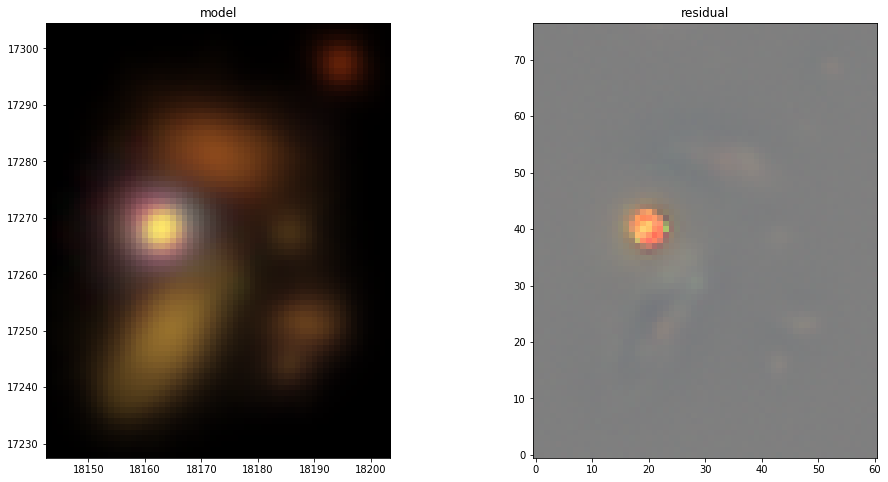

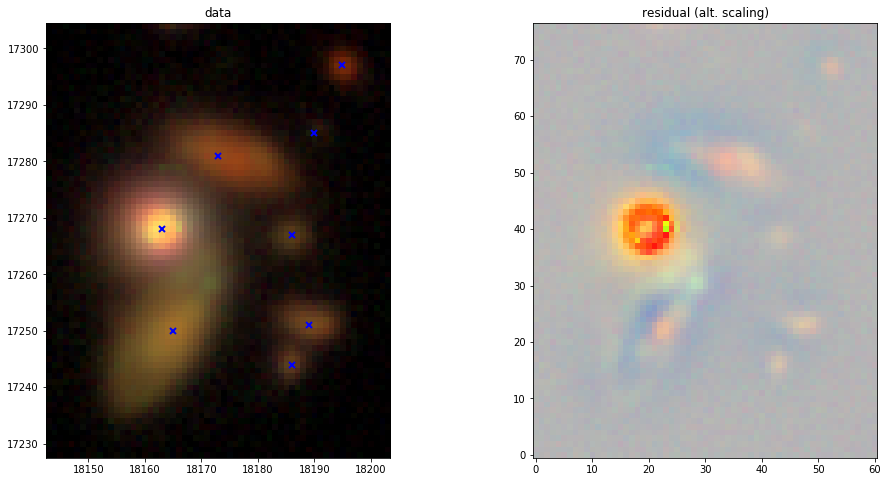

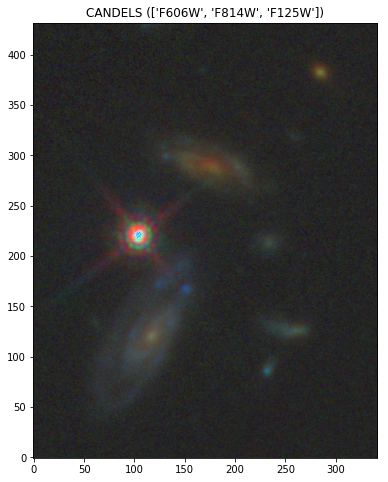

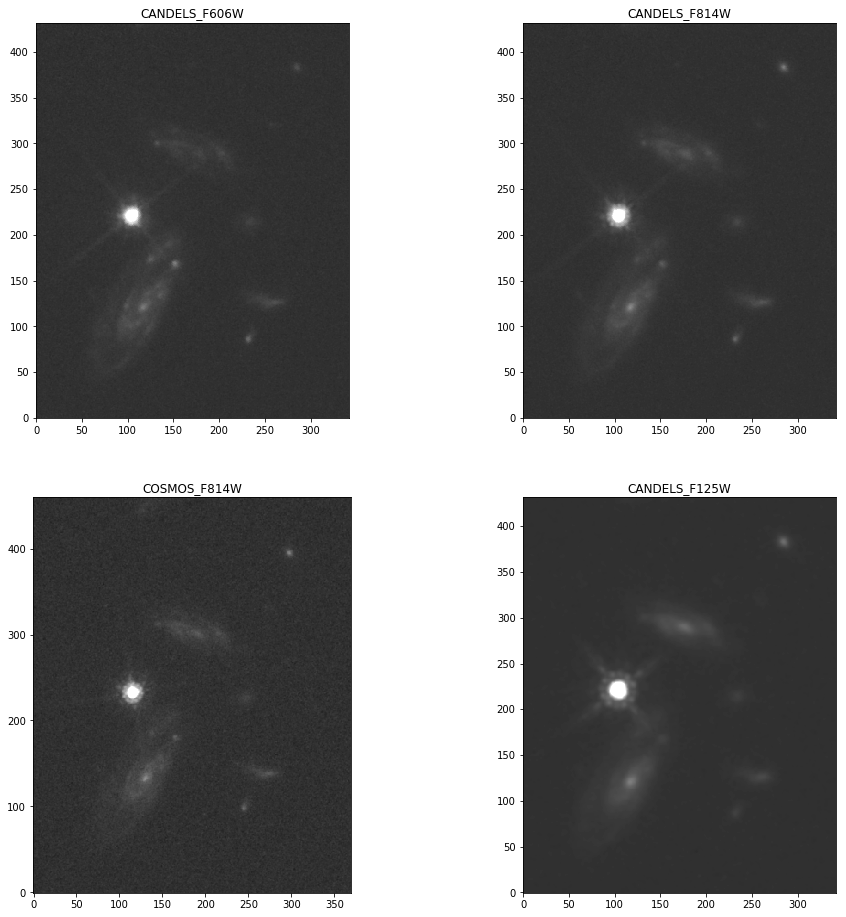

In [15]:
widthfig = 8
fig, axes = plt.subplots(1, 2, figsize=(2*widthfig, widthfig))
axes[0].set_title("model")
axes[1].set_title("residual")
showRGB(fullModel, ax=axes[0])
maxresid=5
asinhscale=4
showRGB(residual, ax=axes[1], minimum=-maxresid, stretch=2*maxresid, Q=0)
fig, axes = plt.subplots(1, 2, figsize=(2*widthfig, widthfig))
showRGB(coadds[:, bbox].image, ax=axes[0], fp=MultibandFootprint(coadds.filters, [result[b][parentIdx].getFootprint() for b in filters]))
maxresid=1
# This doesn't quite work properly - zero residual is not 50% gray for all values of asinhscale
showRGB(residual, ax=axes[1], minimum=-maxresid, stretch=2*maxresid/asinhscale, Q=asinhscale)
axes[0].set_title("data")
axes[1].set_title("residual (alt. scaling)")
# Check if we can make a CANDELS RGB image from F606W, F814W, F125W 
has_candels_all = all(['CANDELS_' + band in imgs_hst for band in filters_candels_all])
if(has_candels_all):
    fig, axes = plt.subplots(1, 1, figsize=(widthfig, widthfig))
    imgs_candels = [imgs_hst['CANDELS_' + band].real.astype('float32')*(1. if band != 'F125W' else 0.5) for band in filters_candels_all]
    variance = np.stack([1. + np.zeros_like(x) for x in imgs_candels])
    mask = np.stack([1 + np.zeros_like(x, dtype='int32') for x in imgs_candels])
    imgs_candels = np.stack(imgs_candels)
    mExposure_candels = MultibandExposure.fromArrays(filters_candels_all, imgs_candels, mask, variance)
    showRGB(mExposure_candels.image, ax=axes, minimum=-0.01, stretch=1/16, Q=10)
    axes.set_title('CANDELS ({})'.format(filters_candels_all))
if n_hst > 0:
    nrows = np.int(np.ceil(n_hst/2))
    ncols = 1 + (n_hst > 1)
    fig_hst, ax_hst = plt.subplots(nrows, ncols, figsize=(ncols*widthfig, nrows*widthfig))
    if n_hst == 1:
        ax_hst = [ax_hst]
    if n_hst > 2:
        ax_hst_new = []
        for axesx in ax_hst:
            for axesy in axesx:
                ax_hst_new.append(axesy)
        print(ax_hst_new)
        ax_hst = ax_hst_new
    for idx, (name_hst, img_hst) in enumerate(imgs_hst.items()):
        print(idx, name_hst)
        scale_flux = 1. if name_hst != 'CANDELS_F125W' else 2.
        norm = ImageNormalize(img_hst, stretch=AsinhStretch(a=1/5), vmin=-0.05*scale_flux, vmax=0.5*scale_flux)
        ax_hst[idx].imshow(img_hst, interpolation='nearest', origin='bottom', cmap='gray', norm=norm)
        ax_hst[idx].set_title(name_hst)